

# Surface Comparison

## Background

Nielsen+15 performed a comparison of 6 Sun-like stars' asteroseismic rotation signatures and surface variability. They are found to agree within uncertainties. They also found discrepancies between ages from asteroseismology and three different gyrochronology relations, implying that stellar age estimations are problematic for Sun-like stars.

They find that asteroseismic rotation periods are systmatically lower than surface rotation periods. If this difference was shown to be statistically significant, it would provide evidence for radial or latitudinal differential rotation between regions the two methods are sensitive to.

Benomar+15 did a similar analysis, but comparing asteroseismic $\nu_{s}\sin i$ to spectroscopic $v\sin i$, which are more well constrained than rotation decoupled from inclination angle.

If a comparison of projected rotation is in an agreement for the majority of stars, we will be able to judge that outlier surface rotation rates are due to spot modulation measuring a multiple of the true rotation, or being subject to uncertainty due to latitudinal differential rotation.



## Our data

We want to:
- Compare to the Benomar+15 work by:
    - Plotting seismic vsini against spectroscopic vsini
- Compare to the Nielsen+15 work by:
    - Plotting seismic vs surface rotation
    - Checking if stars lie on 2x or 0.5x the seismic rotation rates.
- Validate the seismic rotation rates of slowly-rotating outliers by:
    - Identifying these outliers.
    - Seeing whether seismic rotation rates are within the uncertainties
    - Seeing whether the surface rotation rates more closely agree with the vS+19 models.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')
sns.set_palette('colorblind')

/Users/Oliver/Library/Python/3.7/lib/python/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def mnras_size(fig_width_pt, square=False):
    inches_per_pt = 1.0/72.00              # Convert pt to inches
    golden_mean = (np.sqrt(5)-1.0)/2.0     # Most aesthetic ratio
    fig_width = fig_width_pt*inches_per_pt # Figure width in inches
    if square:
        fig_height = fig_width
    else:
        fig_height = fig_width*golden_mean
    return [fig_width,fig_height]

In [3]:
f_ati = pd.read_csv('../data/atium.csv', index_col=0)
ati = f_ati.loc[f_ati.eye_flag != 3]

In [4]:
len(ati)

94

## Compare $v\sin i$

The LEGACY and Kages data report $v\sin i$ for most stars in the sample, which we can use for our comparison. We also have additional data from Campante+15.

In [5]:
# read in legacy
f_lit = pd.read_csv('../data/malatium.csv',usecols=['KIC','vsini','evsini']).rename(
                                columns={'vsini':'L_vsini','evsini':'e_L_vsini'})
lit = f_lit.loc[f_ati.eye_flag != 3]

In [6]:
lit

,KIC,e_L_vsini,L_vsini
0,1435467,0.5,11.9
1,2837475,0.5,23.3
2,3427720,0.5,2.9
3,3456181,0.5,8.5
4,3632418,0.5,8.5
...,...,...,...
90,11295426,0.5,0.5
91,11401755,1.0,4.9
92,11807274,0.5,10.3
93,11853905,0.5,2.3


In [7]:
# read in benomar
B15 = pd.read_csv('../data/benomar_15.csv',sep='\s+')
lit = pd.merge(lit, B15, on='KIC', how='left')
lit.index = ati.index

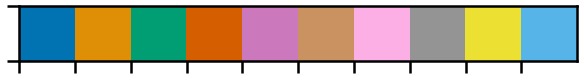

In [8]:
cmap = sns.color_palette('colorblind')
sns.palplot(cmap)

Drop KICs 6603624, 8760414 \& 8938364

In [9]:
ati.drop(ati[ati.KIC == 6603624].index, inplace=True)
ati.drop(ati[ati.KIC == 8760414].index, inplace=True)
ati.drop(ati[ati.KIC == 8938364].index, inplace=True)
lit.drop(lit[lit.KIC == 6603624].index, inplace=True)
lit.drop(lit[lit.KIC == 8760414].index, inplace=True)
lit.drop(lit[lit.KIC == 8938364].index, inplace=True)

/Users/Oliver/Library/Python/3.7/lib/python/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [10]:
sel = (lit.L_vsini > 0).values

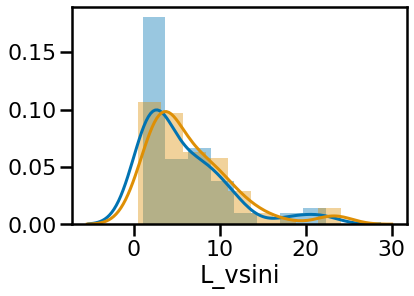

In [11]:
sns.distplot(ati.vsini[sel])
sns.distplot(lit.L_vsini[sel])

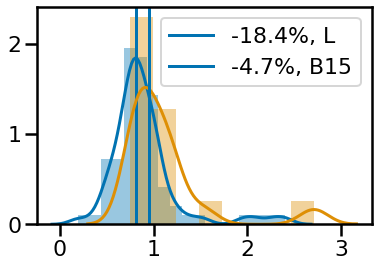

In [12]:
diff = ati.vsini[sel]/lit.L_vsini[sel]
sns.distplot(diff)
m = np.median(diff)
plt.axvline(m, label=f'{100*(m-1):.1f}%, L')

diff = ati.vsini/lit.B_vsini
diff = diff.dropna()
sns.distplot(diff)
m = np.median(diff)
plt.axvline(m, label=f'{100*(m-1):.1f}%, B15')

plt.legend()

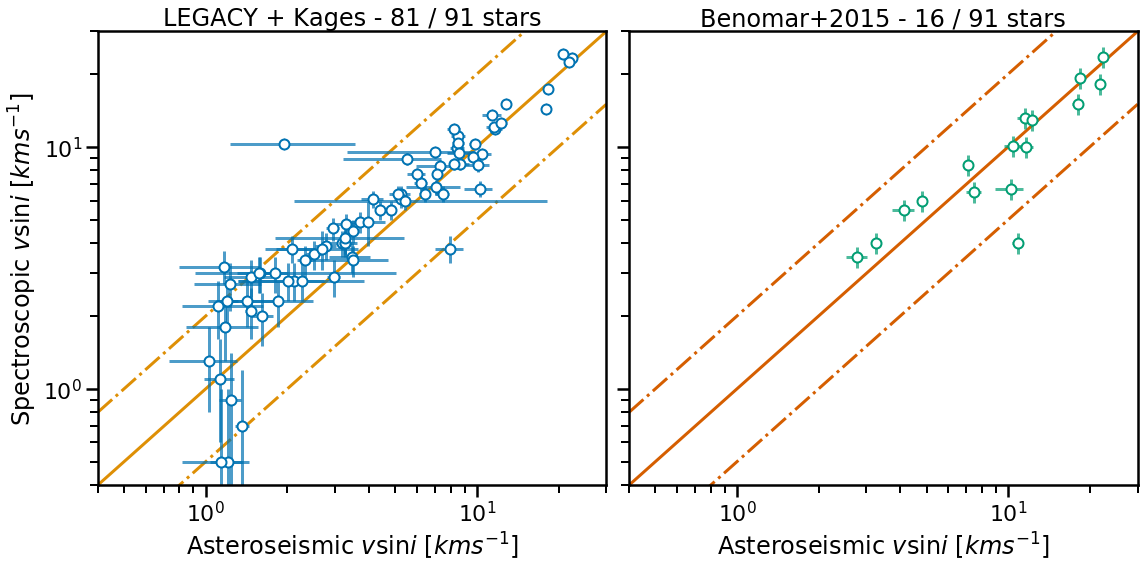

In [13]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharey=True, sharex=True)
ax.scatter(ati.vsini[sel], lit.L_vsini[sel], s=100, fc='w', ec=cmap[0], zorder=3, lw=2)

ax.errorbar(ati.vsini[sel], lit.L_vsini[sel], 
            xerr = [ati.l_vsini[sel], ati.u_vsini[sel]], yerr = lit.e_L_vsini[sel], fmt='|', c=cmap[0], alpha=.7)

ax.set_xlabel(r'Asteroseismic $v\sin i$ $[kms^{-1}]$')
ax2.set_xlabel(r'Asteroseismic $v\sin i$ $[kms^{-1}]$')
ax.set_ylabel(r'Spectroscopic $v\sin i$ $[kms^{-1}]$')

lower=0.4
upper = 30
bs = np.linspace(lower, upper, 100)
ax.plot(bs, bs, ls='-', c=cmap[1], zorder=0)
ax.plot(bs, 2*bs, ls='-.', c=cmap[1], zorder=0)
ax.plot(bs, 0.5*bs, ls='-.', c=cmap[1], zorder=0)

ax.set_xscale('log')
ax.set_yscale('log')

#####
ax2.scatter(ati.vsini, lit.B_vsini, s=100, fc='w', ec=cmap[2], zorder=3, lw=2)

ax2.errorbar(ati.vsini, lit.B_vsini, 
            xerr = [ati.l_vsini, ati.u_vsini], yerr = lit.e_B_vsini, fmt='|', c=cmap[2], alpha=.7)

bs = np.linspace(lower, upper, 100)
ax2.plot(bs, bs, c=cmap[3], zorder=0)
ax2.plot(bs, 2*bs, ls='-.', c=cmap[3], zorder=0)
ax2.plot(bs, 0.5*bs, ls='-.', c=cmap[3], zorder=0)

ax.set_xlim(lower, upper)
ax.set_ylim(lower, upper)

ax.set_title(f'LEGACY + Kages - {len(lit[np.isfinite(lit.L_vsini)])} / {len(lit)} stars')
ax2.set_title(f'Benomar+2015 - {len(lit[np.isfinite(lit.B_vsini)])} / {len(lit)} stars')

fig.tight_layout()
# plt.savefig('/home/oliver/Dropbox/Apps/Overleaf/Malatium/Images/vsini-comparison.pdf', bbox_inches='tight', rasterized=True)
plt.savefig('/Users/Oliver/Dropbox/Apps/Overleaf/Malatium/Images/vsini-comparison.pdf', bbox_inches='tight', rasterized=True)
plt.show()

## Compare rotation periods

Select down only stars with surface rates

In [14]:
spec_lit = lit.copy()

In [15]:
lit = pd.read_csv('../data/lit_spot_rots.csv', index_col=0)
lit = lit.loc[ati.index]

In [16]:
sel = lit.Flag == 1
ati = ati[sel.values]
lit = lit[sel.values]
spec_lit = spec_lit[sel.values]

Stars that don't have values in Garcia but do in others:

In [17]:
ng = lit[np.isnan(lit.GP.values)]
ang = ati[np.isnan(lit.GP.values)]

In [18]:
jvs = ng[np.isfinite(ng.jvsP.values)]
ajvs = ang[np.isfinite(ng.jvsP.values)]

n = ng[np.isfinite(ng.NP.values)]
an = ang[np.isfinite(ng.NP.values)]

In [19]:
martin = np.array([4914923, 5184732, 6116048, 6933899, 10963065])

In [20]:
n15 = lit.loc[lit['KIC'].isin(martin)]
an15 = ati.loc[lit['KIC'].isin(martin).values]

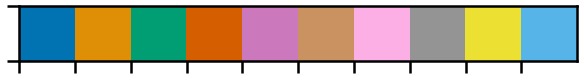

In [21]:
cmap = sns.color_palette('colorblind')
sns.palplot(cmap)

In [22]:
sel = lit['KIC'].isin(martin)

In [23]:
print(len(lit.GP.dropna()))
print(len(jvs.jvsP.dropna()))
print(len(n.NP.dropna()))
print(len(n15.GP.dropna()))

40
7
1
4


Calculate offset to spec values

In [24]:
surf = pd.DataFrame()
surf['surf'] = np.zeros(len(lit))
surf.index = lit.index
surf.loc[lit.GP.dropna().index, 'surf'] = lit.GP.dropna().values
surf.loc[jvs.jvsP.dropna().index, 'surf'] = jvs.jvsP.dropna().values
surf.loc[n.NP.dropna().index, 'surf'] = n.NP.dropna().values

In [25]:
from astropy import constants as const
from astropy import units as u
surf['vsini'] = 2*np.pi*(ati.modrad*const.R_sun.to(u.km)) / (surf.surf *24*60*60) * np.sin(ati.i)

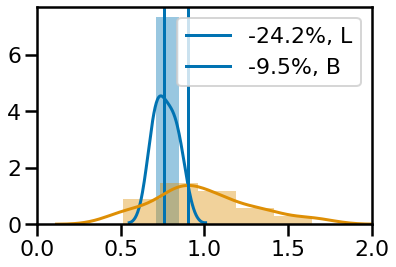

In [26]:
diff = surf.vsini[sel]/spec_lit.L_vsini[sel]
sns.distplot(diff)
m = np.median(diff)
plt.axvline(m, label=f'{100*(m-1):.1f}%, L')
plt.xlim(0, 2)

sel = spec_lit.B_vsini > 0
diff = surf.vsini[sel]/spec_lit.B_vsini[sel]
sns.distplot(diff)
m = np.median(diff)
plt.axvline(m, label=f'{100*(m-1):.1f}%, B')
plt.legend()

And how about seismo to surface:

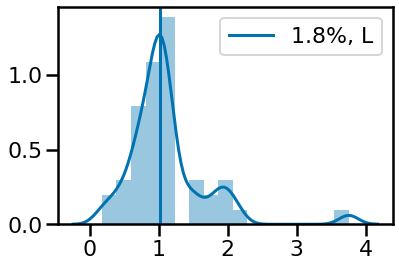

In [27]:
diff = surf.surf/ati.P
sns.distplot(diff)
m = np.median(diff)
plt.axvline(m, label=f'{100*(m-1):.1f}%, L')
plt.legend()

### Fitting a line to rotation

In [28]:
lit.index = ati.index

In [29]:
ati['litP'] = np.nan
ati['e_litP'] = np.nan
ati['litsource'] = ''
for idx in lit.index:
    l = lit.loc[idx]
    if np.isfinite(l.GP):
        ati.loc[idx, 'litP'] = l.GP
        ati.loc[idx, 'e_litP'] = l.e_GP
        ati.loc[idx, 'litsource'] = 'G+14'
    elif np.isfinite(l.jvsP):
        ati.loc[idx, 'litP'] = l.jvsP
        ati.loc[idx, 'e_litP'] = l.e_jvsP
        ati.loc[idx, 'litsource'] = 'vS+16'
    elif np.isfinite(l.NP):
        ati.loc[idx, 'litP'] = l.NP
        ati.loc[idx, 'e_litP'] = l.e_NP
        ati.loc[idx, 'litsource'] = 'N+15'

In [47]:
s = (ati.litP < 1.8*ati.P) & (ati.litP > 0.2 * ati.P)

In [48]:
x = ati.P.values[s]
xerr = np.array([max(u, l) for u, l in list(zip(ati.u_P, ati.l_P))])[s]
y = ati.litP.values[s]
yerr = ati.e_litP.values[s]

def e(a, siga, b, sigb):
    #return sigma for a/b
    rhs = (siga / b)**2 + ((a*sigb)/b**2)**2
    return np.sqrt(rhs)

z = x/y
zerr = e(x, xerr, y, yerr)

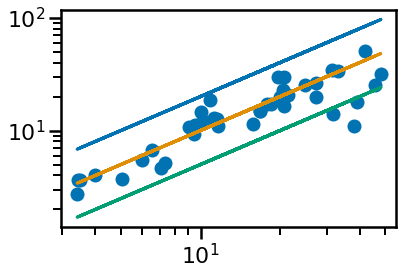

In [49]:
plt.scatter(x, y)
plt.plot(x, 2*x)
plt.plot(x,x)
plt.plot(x, 0.5*x)
plt.yscale('log')
plt.xscale('log')

In [50]:
import pymc3 as pm
with pm.Model() as model:
    mu = pm.Normal('mu', 1., 0.5, testval=1.)
    ll = pm.Normal('ll', mu=mu, sigma=zerr[:20], observed=z[:20])
    
    trace = pm.sample(chains=4, draws=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [mu]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:04<00:00, 2061.58draws/s]
The acceptance probability does not match the target. It is 0.8965075728522205, but should be close to 0.8. Try to increase the number of tuning steps.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1296aab50>,
      dtype=object)

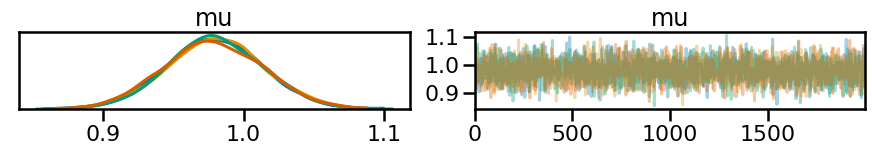

In [51]:
pm.traceplot(trace)

In [52]:
print(f"{np.median(trace['mu']):.2f} pm {np.std(trace['mu']):.2f}")

0.98 pm 0.03


Plotting

In [37]:
ati.litsource

0      G+14
1      G+14
2     vS+16
4      G+14
5      G+14
6      G+14
7      G+14
8      G+14
9      G+14
12     G+14
14     G+14
16     G+14
18     G+14
20     G+14
21     G+14
23     G+14
24     G+14
25     G+14
26     G+14
27     G+14
28     G+14
30     G+14
31     G+14
32     N+15
39     G+14
40    vS+16
42     G+14
43     G+14
44     G+14
45     G+14
46     G+14
47     G+14
49     G+14
50     G+14
51     G+14
52     G+14
54     G+14
56     G+14
57     G+14
58     G+14
60     G+14
61     G+14
64     G+14
74    vS+16
76    vS+16
80    vS+16
87    vS+16
91    vS+16
Name: litsource, dtype: object

In [72]:
# Compute the quantiles of the predicted line and plot them.
A = np.vander(bs, 1)
B = np.reshape(np.array([trace['mu']]), (len(trace['mu']), 1))
lines = np.dot(B, A.T)
quantiles = np.percentile(lines, [16, 84], axis=0)
ax.fill_between(bs, quantiles[0], quantiles[1], color="#8d44ad", alpha=0.5)

In [78]:
len(quantiles[0])

100

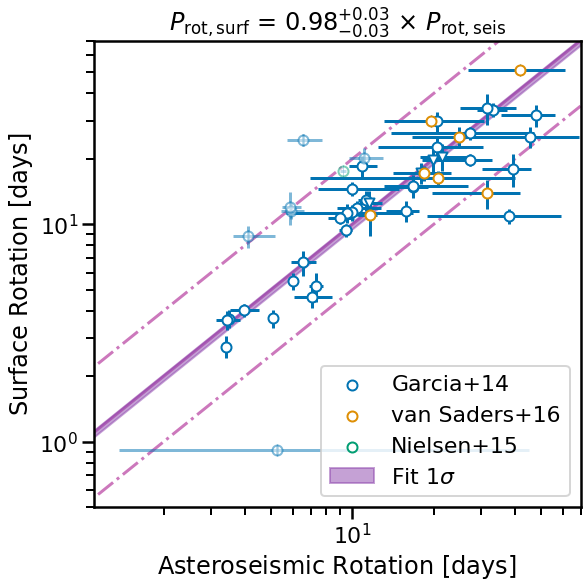

In [94]:
sel = ati['KIC'].isin(martin)

fig, ax = plt.subplots(figsize=mnras_size(595, square=True))

sel = ati.litsource == 'G+14'
ssel = ati.KIC.isin(martin)

ax.scatter(ati.P[sel][s][~ssel], ati.litP[sel][s][~ssel], label='Garcia+14', s=100, fc='w', ec=cmap[0], zorder=3, lw=2)
ax.scatter(ati.P[sel][~s][~ssel], ati.litP[sel][~s][~ssel], s=100, fc='w', ec=cmap[0], zorder=3, lw=2, alpha=.5)
ax.errorbar(ati.P[sel][s][~ssel], ati.litP[sel][s][~ssel], xerr=[ati.l_P[sel][s][~ssel], ati.u_P[sel][s][~ssel]], yerr=ati.e_litP[sel][s][~ssel],
                c=cmap[0], fmt='|')
ax.errorbar(ati.P[sel][~s][~ssel], ati.litP[sel][~s][~ssel], xerr=[ati.l_P[sel][~s][~ssel], ati.u_P[sel][~s][~ssel]], yerr=ati.e_litP[sel][~s][~ssel],
                c=cmap[0], alpha=.5, fmt='|')

sel = ati.litsource == 'G+14'
ssel = ati.KIC.isin(martin)
ax.scatter(ati.P[sel][s][ssel], ati.litP[sel][s][ssel], s=100, fc='w', marker='v', ec=cmap[0], zorder=3, lw=2)
ax.errorbar(ati.P[sel][s][ssel], ati.litP[sel][s][ssel], xerr=[ati.l_P[sel][s][ssel], ati.u_P[sel][s][ssel]], yerr=ati.e_litP[sel][s][ssel],
                c=cmap[0], fmt='|')


sel = ati.litsource == 'vS+16'
ax.scatter(ati.P[sel][s], ati.litP[sel][s], label='van Saders+16', s=100, fc='w', ec=cmap[1], zorder=3, lw=2)
ax.scatter(ati.P[sel][~s], ati.litP[sel][~s],  s=100, fc='w', ec=cmap[1], zorder=3, lw=2, alpha=.5)
ax.errorbar(ati.P[sel][s], ati.litP[sel][s], xerr=[ati.l_P[sel][s], ati.u_P[sel][s]], yerr=ati.e_litP[sel][s],
                c=cmap[0], fmt='|')
ax.errorbar(ati.P[sel][~s], ati.litP[sel][~s], xerr=[ati.l_P[sel][~s], ati.u_P[sel][~s]], yerr=ati.e_litP[sel][~s],
                c=cmap[0], alpha=.5, fmt='|')

sel = ati.litsource == 'N+15'
ax.scatter(ati.P[sel][s], ati.litP[sel][s], label='Nielsen+15', s=100, fc='w', ec=cmap[2], zorder=3, lw=2)
ax.scatter(ati.P[sel][~s], ati.litP[sel][~s], s=100, fc='w', ec=cmap[2], zorder=3, lw=2, alpha=.5)
ax.errorbar(ati.P[sel][s], ati.litP[sel][s], xerr=[ati.l_P[sel][s], ati.u_P[sel][s]], yerr=ati.e_litP[sel][s],
                c=cmap[0], fmt='|')
ax.errorbar(ati.P[sel][~s], ati.litP[sel][~s], xerr=[ati.l_P[sel][~s], ati.u_P[sel][~s]], yerr=ati.e_litP[sel][~s],
                c=cmap[0], alpha=.5, fmt='|')


ax.set_xlabel(r'Asteroseismic Rotation $[\rm{days}]$')
ax.set_ylabel(r'Surface Rotation $[\rm{days}]$')

upper = 70
ax.set_xlim(1.1, 70.)
ax.set_ylim(0.5, 70.)
bs = np.linspace(0, upper, 100)
ax.plot(bs, bs, ls='-', c=cmap[4], zorder=0)
ax.plot(bs, 2*bs, ls='-.', c=cmap[4], zorder=0)
ax.plot(bs, 0.5*bs, ls='-.', c=cmap[4], zorder=0)

# Compute the quantiles of the predicted line and plot them.
A = np.vander(bs, 1)
B = np.reshape(np.array([trace['mu']]), (len(trace['mu']), 1))
lines = np.dot(B, A.T)
quantiles = np.percentile(lines, [16, 84], axis=0)
ax.fill_between(bs, quantiles[0]*bs, quantiles[1]*bs, color="#8d44ad", alpha=0.5, label=r'Fit 1$\sigma$')

l, m, u = np.quantile(trace['mu'], [.16, .50, .84], axis=0)
l = m - l
u = u - m
ax.set_title(fr'$P_{{\rm rot, surf}}$ = {m:.2f}$^{{+{u:.2f}}}_{{-{l:.2f}}}$ $\times\ P_{{\rm rot, seis}}$')

ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc='lower right')

fig.tight_layout()
# plt.savefig('/home/oliver/Dropbox/Apps/Overleaf/Malatium/Images/surf-seis-comparison.pdf', bbox_inches='tight', rasterized=True)
plt.savefig('/Users/Oliver/Dropbox/Apps/Overleaf/Malatium/Images/surf-seis-comparison.pdf', bbox_inches='tight', rasterized=True)
plt.show()